In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np
import torch
import torch.nn as nn

# Create sequences for time-series data
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

# Hybrid BiGRU-LSTM Model
class HybridBiGRU_LSTM(nn.Module):
    def __init__(self, input_size, gru_hidden_size, lstm_hidden_size1, lstm_hidden_size2, dropout_rate=0.2):
        super(HybridBiGRU_LSTM, self).__init__()
        # BiGRU layer
        self.bi_gru = nn.GRU(input_size, gru_hidden_size, batch_first=True, bidirectional=True)

        # First LSTM layer
        self.lstm1 = nn.LSTM(gru_hidden_size * 2, lstm_hidden_size1, batch_first=True)

        # Second and third LSTM layers
        self.lstm2 = nn.LSTM(lstm_hidden_size1, lstm_hidden_size2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden_size2, lstm_hidden_size2, batch_first=True)

        # Dropout layers
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

        # Dense (fully connected) layer
        self.fc = nn.Linear(lstm_hidden_size2, input_size)

    def forward(self, x):
        # BiGRU layer
        x, _ = self.bi_gru(x)

        # First LSTM layer
        x, _ = self.lstm1(x)
        x = self.dropout1(x)

        # Second LSTM layer
        x, _ = self.lstm2(x)
        x = self.dropout2(x)

        # Third LSTM layer
        x, _ = self.lstm3(x)
        x = self.dropout3(x)

        # Fully connected layer (using only the last time step output)
        x = self.fc(x[:, -1, :])
        return x

# Train the Model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs = 10):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    history = {"train_loss": [], "val_loss": []}

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        history["val_loss"].append(val_loss)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot the loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history["train_loss"], label="Train Loss", marker='o')
    plt.plot(history["val_loss"], label="Validation Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid()
    plt.show()

    return model, history

# Plot Predictions
def plot_predictions(dates, y_train, y_pred_train, y_val, y_pred_val, feature_names=None, time_interval=10):
    # Determine number of features
    num_features = y_train.shape[1] if len(y_train.shape) > 1 else 1

    # Create subplot grid
    fig, axes = plt.subplots(num_features, 1, figsize=(16, 8*num_features), sharex=True)

    # If only one feature, convert axes to list for consistent indexing
    if num_features == 1:
        axes = [axes]

    # Ensure feature names
    if feature_names is None:
        feature_names = [f'Feature {i+1}' for i in range(num_features)]

    # Split dates for training and validation
    train_dates = dates[:len(y_train)]
    val_dates = dates[len(y_train):]

    # Plot for each feature
    for i in range(num_features):
        # Extract i-th feature
        train_true = y_train[:, i] if num_features > 1 else y_train
        train_pred = y_pred_train[:, i] if num_features > 1 else y_pred_train
        val_true = y_val[:, i] if num_features > 1 else y_val
        val_pred = y_pred_val[:, i] if num_features > 1 else y_pred_val

        # Plot on corresponding subplot with 3 decimal points
        axes[i].plot(train_dates, train_true, label="Train True", alpha=0.7)
        axes[i].plot(train_dates, train_pred, label="Train Pred", alpha=0.7)
        axes[i].plot(val_dates, val_true, label="Val True", alpha=0.7)
        axes[i].plot(val_dates, val_pred, label="Val Pred", alpha=0.7)

        # Set y-axis to show all ticks formatted with 2 decimal places
        axes[i].yaxis.set_major_locator(mticker.AutoLocator())
        axes[i].yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))

        # Set x-axis formatting for minutes on the bottom-most subplot
        axes[-1].xaxis.set_major_locator(mdates.MinuteLocator(interval=time_interval)) # set time interval according to your needs
        # axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
        axes[-1].xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%Y %H:%M"))
        plt.xticks(rotation=60)  # Rotate dates for better readability

        # Set title, labels, legend, and grid
        axes[i].set_title(f"{feature_names[i]} - True vs Predicted")
        axes[i].set_ylabel("Value")
        axes[i].set_xlabel("Time")
        axes[i].legend()
        axes[i].grid()

    # Ensure the common x-label is set on the bottom subplot
    axes[-1].set_xlabel("Time")

    plt.show()


In [27]:
import pandas as pd

# Only need the open, close, low, high
data = pd.read_csv(r'/content/dataset.csv')

# Print the data
print(data.head())

# Load the dataset
data.columns = [i.lower() for i in data.columns]

data.isna().any()

data.duplicated().sum()

data['date'] = pd.to_datetime(data['date'], dayfirst=True)
data.set_index('date',inplace=True)
data.head()


               date    open    high     low   close
0  15-01-2024 09:34  365.90  366.00  365.55  366.00
1  15-01-2024 09:35  366.00  366.50  366.00  366.15
2  15-01-2024 09:36  366.15  366.65  365.95  366.00
3  15-01-2024 09:37  366.00  366.45  366.00  366.00
4  15-01-2024 09:38  366.00  366.70  366.00  366.50


,open,high,low,close
date,,,,
2024-01-15 09:34:00,365.90,366.00,365.55,366.00
2024-01-15 09:35:00,366.00,366.50,366.00,366.15
2024-01-15 09:36:00,366.15,366.65,365.95,366.00
2024-01-15 09:37:00,366.00,366.45,366.00,366.00
2024-01-15 09:38:00,366.00,366.70,366.00,366.50


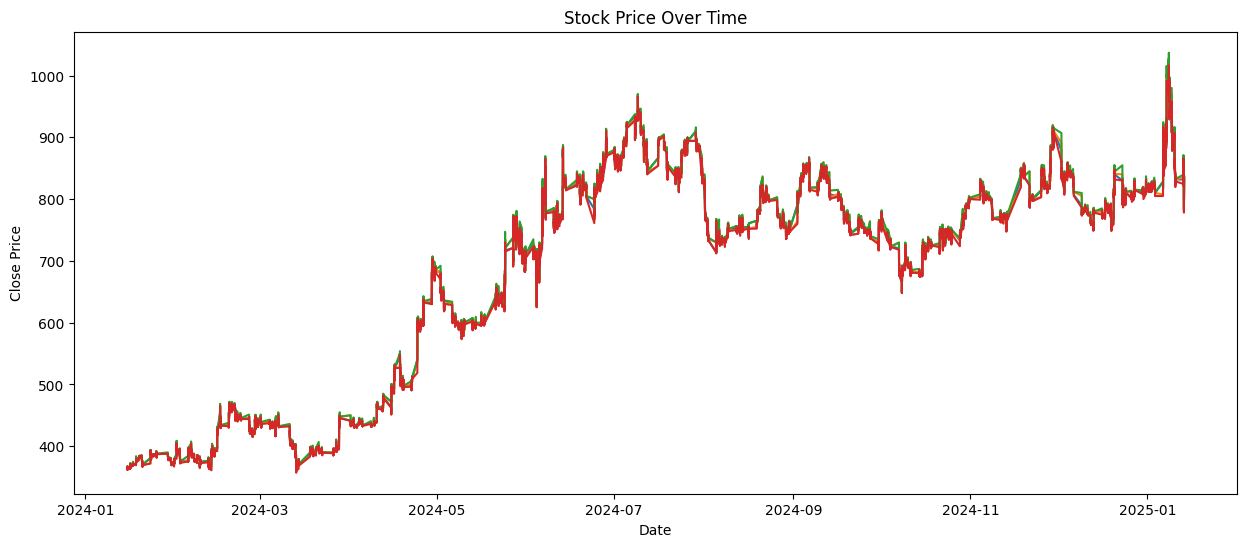

In [5]:
# plot the data
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
plt.plot(data['close'])
plt.plot(data['open'])
plt.plot(data['high'])
plt.plot(data['low'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Stock Price Over Time')
plt.show()


In [6]:
# Function to generate feature technical indicators
def get_technical_indicators(dataset):

    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['close'].rolling(window = 7).mean()
    dataset['ma21'] = dataset['close'].rolling(window = 21).mean()

    # Create MACD
    dataset['12ema'] = dataset['close'].ewm(span=12).mean()
    dataset['26ema'] = dataset['close'].ewm(span=26).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = dataset['close'].rolling(window = 20).std()
    dataset['upper_band'] = (dataset['close'].rolling(window = 20).mean()) + (dataset['20sd']*2)
    dataset['lower_band'] = (dataset['close'].rolling(window = 20).mean()) - (dataset['20sd']*2)

    # Create Exponential moving average
    dataset['ema'] = dataset['close'].ewm(com=0.5).mean()

    # Create Momentum
    dataset['momentum'] = (dataset['close']/100)-1

    return dataset

technical_data = data.copy()
technical_data = get_technical_indicators(technical_data)

def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(16, 10), dpi=1000)

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.25)
    plt.title('Technical indicators for Stock Prices - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.plot(dataset['momentum'],label='Momentum', color='b',linestyle='-')
    plt.hlines(15, dataset.index.min(), dataset.index.max(), colors='g', linestyles='--')
    plt.hlines(-15, dataset.index.min(), dataset.index.max(), colors='g', linestyles='--')

    plt.legend()
    plt.show()

plot_technical_indicators(technical_data, 365)

In [7]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

sequence_length = 10
X, y = create_sequences(scaled_data, seq_length=sequence_length)
print(X.shape, y.shape)

# Split into training and validation datasets
split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_val, y_val = X[split_idx:], y[split_idx:]

# Create DataLoaders
batch_size = 16
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)



torch.Size([89966, 10, 4]) torch.Size([89966, 4])


In [8]:
# Model initialization
input_size = len(data.columns)
gru_hidden_size = 100
lstm_hidden_size1 = 100
lstm_hidden_size2 = 50
dropout_rate = 0.2

model = HybridBiGRU_LSTM(input_size, gru_hidden_size, lstm_hidden_size1, lstm_hidden_size2, dropout_rate)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


cuda
Epoch [1/5], Train Loss: 0.0013, Val Loss: 0.0003
Epoch [2/5], Train Loss: 0.0006, Val Loss: 0.0003
Epoch [3/5], Train Loss: 0.0006, Val Loss: 0.0010
Epoch [4/5], Train Loss: 0.0005, Val Loss: 0.0001
Epoch [5/5], Train Loss: 0.0005, Val Loss: 0.0002


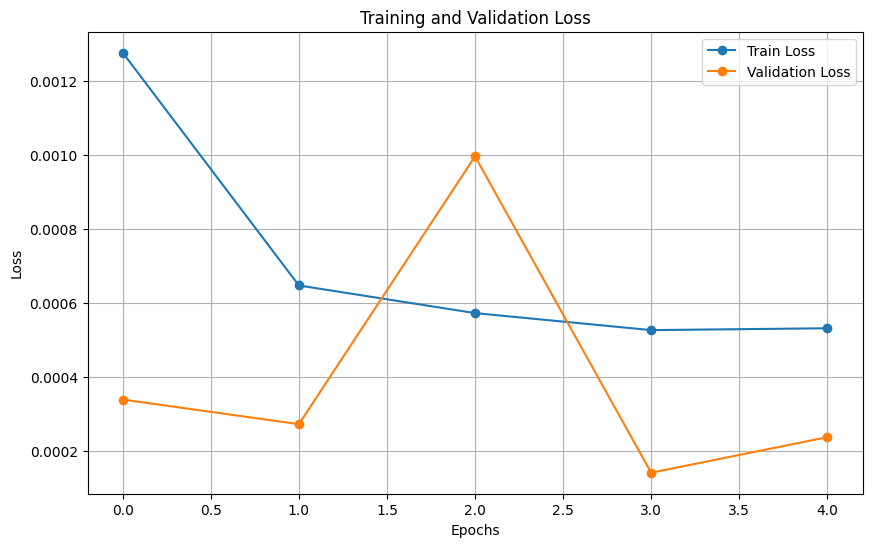

In [9]:
# Training
num_epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
trained_model, loss_history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


In [10]:
# Evaluate model
model.eval()
with torch.no_grad():
    y_train_predictions = model(X_train.to(device)).cpu().numpy()
    y_val_predictions = model(X_val.to(device)).cpu().numpy()

In [11]:
print(len(y_train_predictions), len(y_val_predictions))

71972 17994


20 10 10 10 10


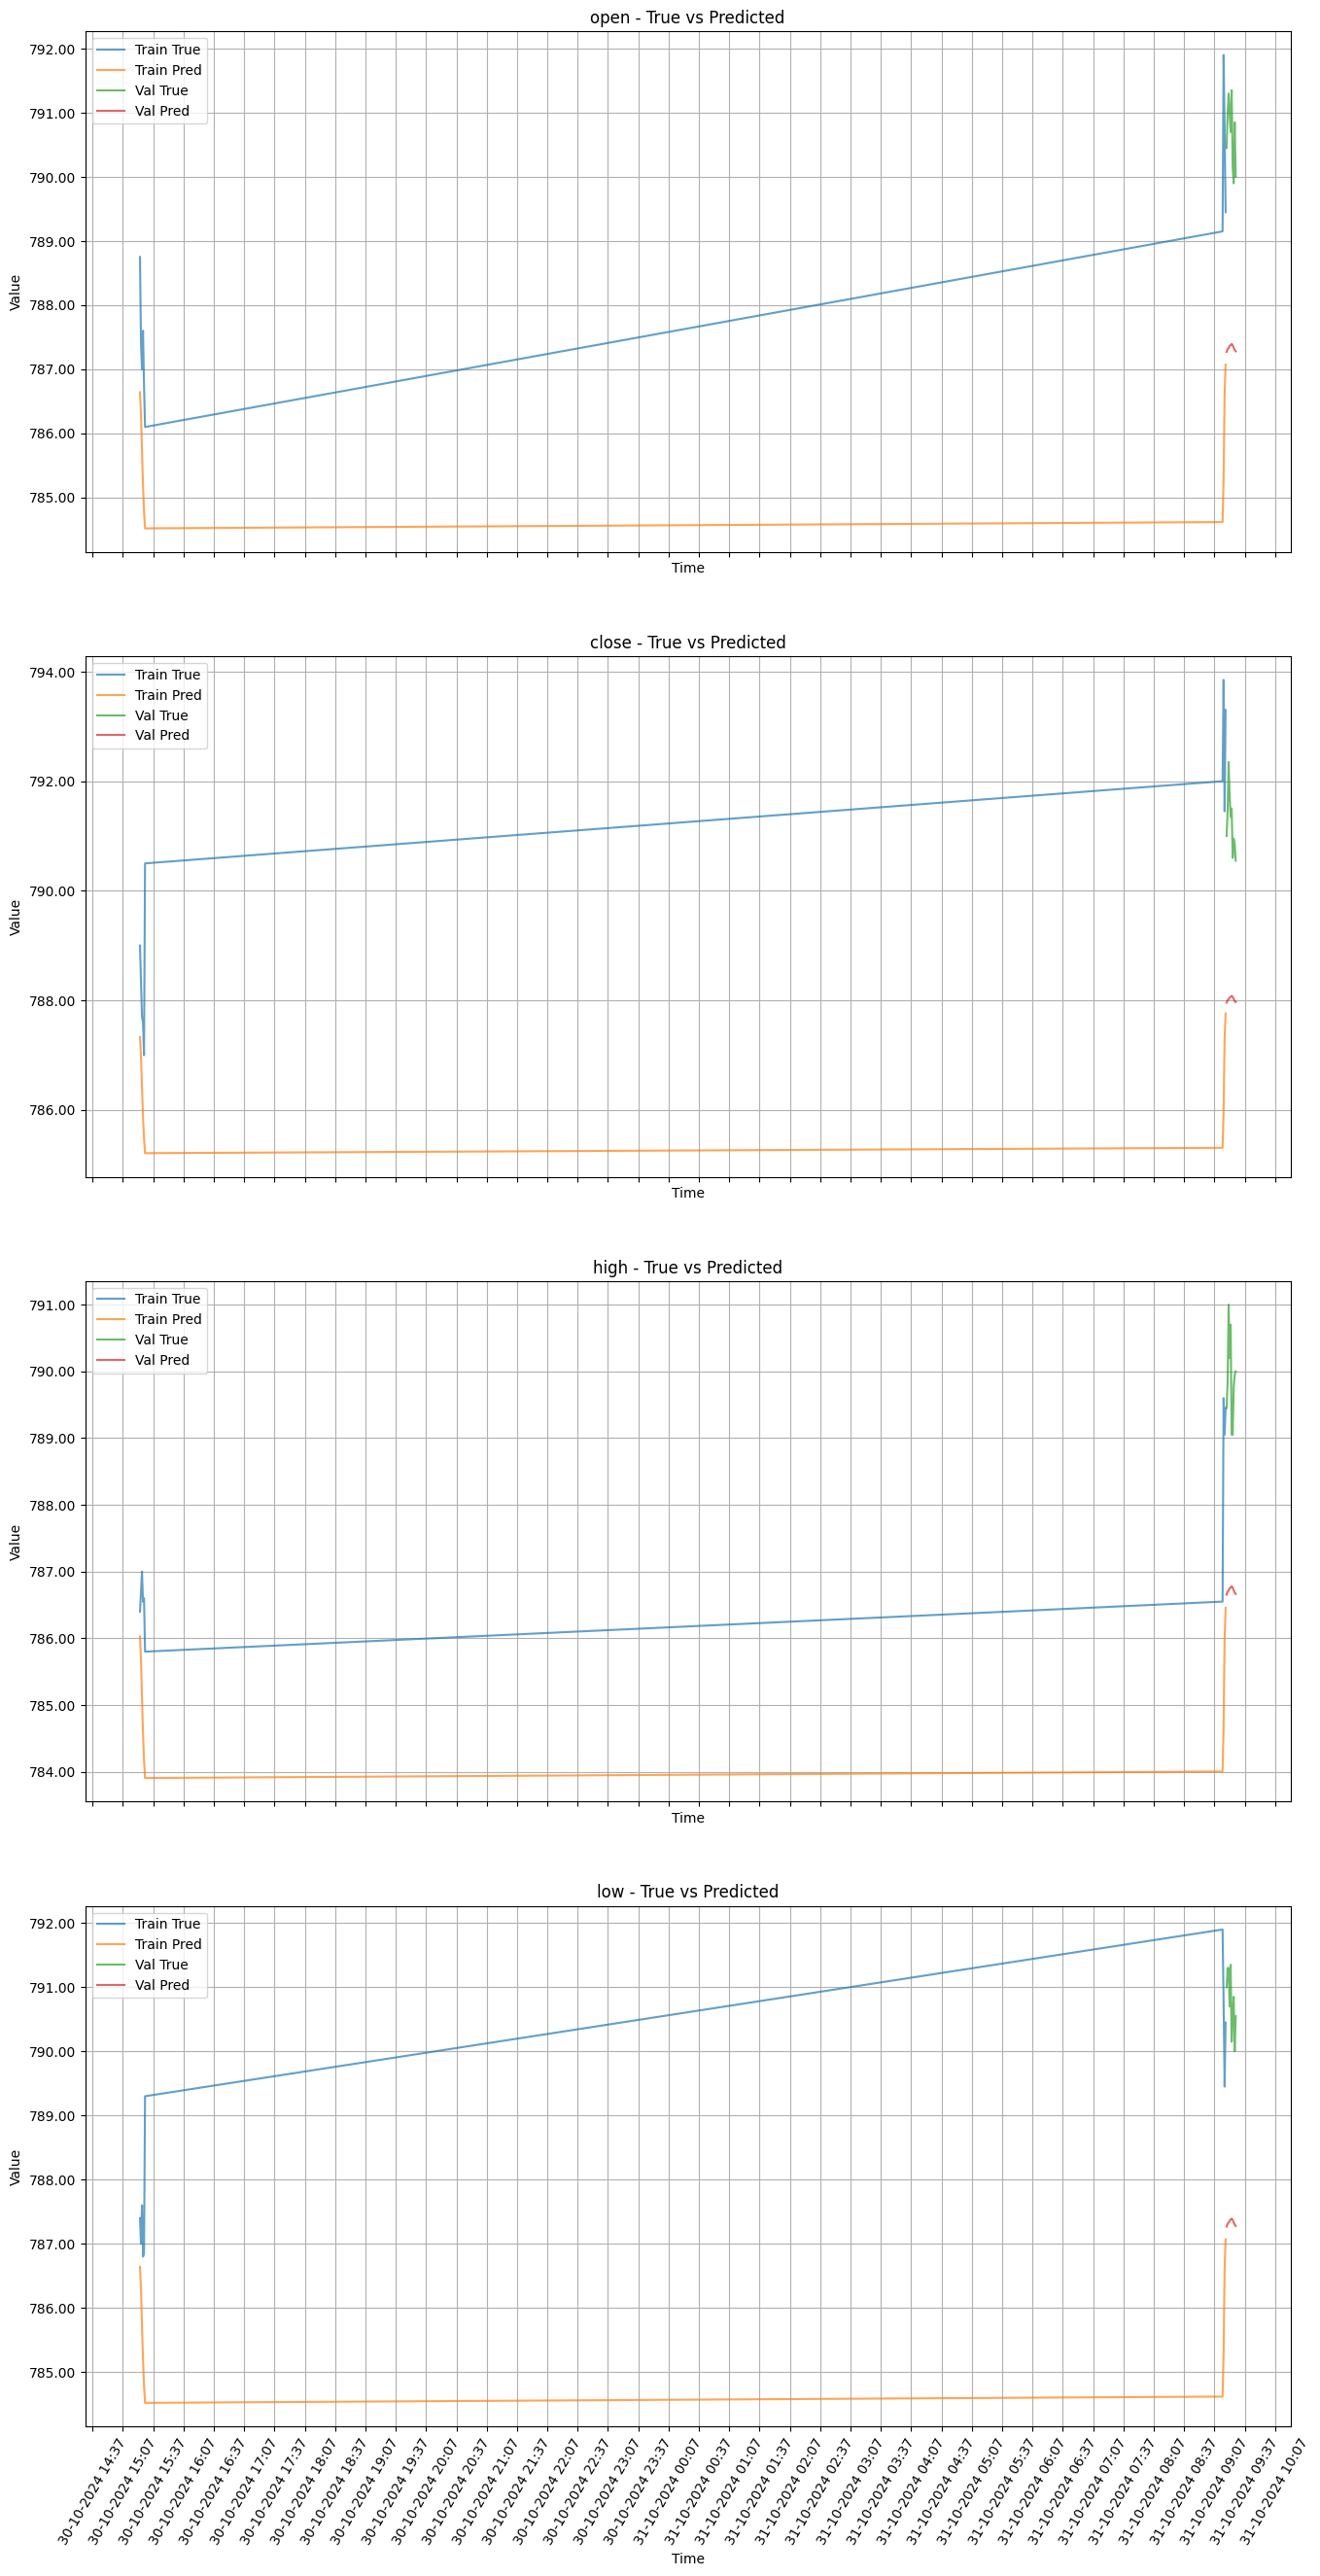

In [12]:
dates = data.index[sequence_length:]

num_points = 10
dates = dates[len(y_train)-num_points:len(y_train)+num_points]
y_train_plot = scaler.inverse_transform(y_train)[-num_points:]
y_pred_train_plot = scaler.inverse_transform(y_train_predictions)[-num_points:]
y_val_plot = scaler.inverse_transform(y_val)[:num_points]
y_pred_val_plot = scaler.inverse_transform(y_val_predictions)[:num_points]

print(len(dates), len(y_train_plot), len(y_pred_train_plot), len(y_val_plot), len(y_pred_val_plot))

plot_predictions(
    dates,
    y_train_plot,
    y_pred_train_plot,
    y_val_plot,
    y_pred_val_plot,
    feature_names=['open', 'close', 'high', 'low'],
    time_interval=30,
)


In [24]:
y_train_predictions= scaler.inverse_transform(y_train_predictions)

In [25]:
# Convert the predictions to a dataframe along with their date/timestamps
y_pred_train_df = pd.DataFrame(y_train_predictions, columns=data.columns)
y_pred_train_df.index = data.index[sequence_length:sequence_length + len(y_train_predictions)]

In [26]:
y_pred_train_df


,open,high,low,close
date,,,,
2024-01-15 09:44:00,389.753662,390.655182,389.672882,390.003510
2024-01-15 09:45:00,389.753601,390.655151,389.672882,390.003510
2024-01-15 09:46:00,389.753662,390.655151,389.672882,390.003510
2024-01-15 09:47:00,389.753601,390.655151,389.672882,390.003510
2024-01-15 09:48:00,389.753601,390.655151,389.672882,390.003510
...,...,...,...,...
2024-10-30 15:29:00,784.519409,785.211121,783.906006,784.518616
2024-10-31 09:15:00,784.617493,785.309082,784.003967,784.616638
2024-10-31 09:16:00,785.277100,785.968079,784.663208,785.275940


In [21]:
y_val_predictions=scaler.inverse_transform(y_val_predictions)

In [22]:
y_val_df = pd.DataFrame(y_val_predictions, columns=data.columns)
y_val_df.index = data.index[sequence_length + len(y_train_predictions):sequence_length + len(y_train_predictions) + len(y_val_predictions)]

In [23]:
y_val_df

,open,high,low,close
date,,,,
2024-10-31 09:19:00,787.270020,787.958923,786.654846,787.268005
2024-10-31 09:20:00,787.314697,788.003601,786.699524,787.312622
2024-10-31 09:21:00,787.331543,788.020264,786.716248,787.329407
2024-10-31 09:22:00,787.361450,788.050232,786.746277,787.359375
2024-10-31 09:23:00,787.378052,788.066772,786.762817,787.375916
...,...,...,...,...
2025-01-13 15:25:00,816.083130,816.750610,815.455017,816.076904
2025-01-13 15:26:00,818.837524,819.502563,818.208191,818.830627
2025-01-13 15:27:00,821.338501,822.001160,820.708374,821.330994
